In [ ]:
# Adopted from Andrew's project

from training_defs import load_spectral_data, get_dataloaders
from model import MLP
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

X, y = load_spectral_data()
train_loader, val_loader = get_dataloaders(X, y)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X.shape[1], h_dim=128, out_dim=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50
train_losses, val_losses = [], []

In [ ]:
for epoch in range(1, n_epochs+1):
    model.train()
    tot_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        tot_train += loss.item() * xb.size(0)
    train_losses.append(tot_train / len(train_loader.dataset))

    model.eval()
    tot_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            tot_val += criterion(model(xb), yb).item() * xb.size(0)
    val_losses.append(tot_val / len(val_loader.dataset))

    print(f"epoch {epoch:02d}  train mse: {train_losses[-1]:.4f}  val mse: {val_losses[-1]:.4f}")

epoch 01  train mse: 0.0908  val mse: 0.0565
epoch 02  train mse: 0.0550  val mse: 0.0492
epoch 03  train mse: 0.0481  val mse: 0.0440
epoch 04  train mse: 0.0430  val mse: 0.0389
epoch 05  train mse: 0.0418  val mse: 0.0380
epoch 06  train mse: 0.0363  val mse: 0.0350
epoch 07  train mse: 0.0330  val mse: 0.0297
epoch 08  train mse: 0.0303  val mse: 0.0271
epoch 09  train mse: 0.0266  val mse: 0.0349
epoch 10  train mse: 0.0279  val mse: 0.0256
epoch 11  train mse: 0.0258  val mse: 0.0258
epoch 12  train mse: 0.0241  val mse: 0.0219
epoch 13  train mse: 0.0224  val mse: 0.0212
epoch 14  train mse: 0.0199  val mse: 0.0193
epoch 15  train mse: 0.0205  val mse: 0.0184
epoch 16  train mse: 0.0177  val mse: 0.0169
epoch 17  train mse: 0.0174  val mse: 0.0169
epoch 18  train mse: 0.0174  val mse: 0.0182
epoch 19  train mse: 0.0250  val mse: 0.0191
epoch 20  train mse: 0.0167  val mse: 0.0188
epoch 21  train mse: 0.0158  val mse: 0.0214
epoch 22  train mse: 0.0151  val mse: 0.0347
epoch 23  

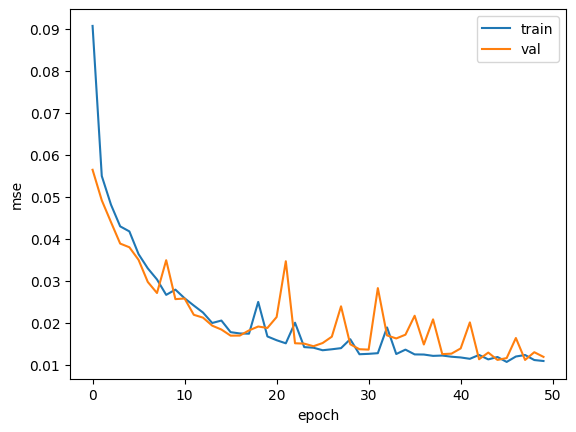

In [6]:
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("epoch"); plt.ylabel("mse"); plt.legend(); plt.show()

torch.save(model.state_dict(), "spectra_mlp.pth")

In [5]:
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

r2 = r2_score(all_targets, all_preds, multioutput="uniform_average")
rmse = root_mean_squared_error(all_targets, all_preds)

print(f"validation r^2:  {r2:.4f}")
print(f"validation rmse: {rmse:.4f}")

validation r^2:  0.8630
validation rmse: 0.1076
